# Import Module

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from osgeo import gdal
from math import  e, log#, exp,
from numpy import exp

# Define File Location

In [11]:
b6 = gdal.Open('D:/Study/Bachelor Thesis (Skripsi)/Krakatau/BTSWIR_test_celcius')
b10 = gdal.Open('D:/Study/Bachelor Thesis (Skripsi)/Krakatau/BTTIR_test_celcius')
datatei = gdal.Open('D:/Study/Bachelor Thesis (Skripsi)/Krakatau/TEI_2018-10-01')

In [12]:
b1 = b6.GetRasterBand(1)
b2 = b10.GetRasterBand(1)
b3 = datatei.GetRasterBand(1)

In [13]:
A3 = b3.ReadAsArray()
A1R = b1.ReadAsArray()
A2R = b2.ReadAsArray()
iiter, jiter = A2R.shape
print(A2R.shape)
print(iiter)

(40, 32)
40


# Radiance to Brightness Temperature Conversion

In [14]:
def temperature(x, cw):
    c1 = 1.191042e8
    c2 = 1.4393e4
    T = c2 / (cw * (log(c1 * ((cw**(-5)) / x) + 1))) 
    return T

def radiance(x, cw):
   # spectral_radiance = (0.0000000000000003741*(cw**(-5.))/ (exp(0.0143876869/(cw*x))-1.)*1000000)
    #spectral_radiance = 0.0000000000000003741*(cw**(-5.)) / (exp(0.0143876869/((cw*x)-1.)))
    spectral_radiance = (1.191042e8 * (cw ** (-5.)) / (e**(1.43878E4/(cw * x))-1.))
    return spectral_radiance

print(temperature(25,1.609))
print(radiance(527,10.9))

688.176213478374
68.8697329514084


In [15]:
cw1 = 1.609 # This is centralwavelength for band SWIR
cw2 = 10.900 # This is centralwavelength for band TIR
A1 = np.zeros((iiter, jiter))
A2 = np.zeros((iiter, jiter))
for i in range(0,iiter):
    for j in range(0, jiter):
        A1[i,j] = A1R[i,j] #temperature(A1R[i,j], cw1) 
        A2[i,j] = A2R[i,j]#temperature(A2R[i,j], cw2)

In [18]:

print(A1.shape)
print(A2R.max())
print(A2.max())

(40, 32)
169.30704
169.30703735351562


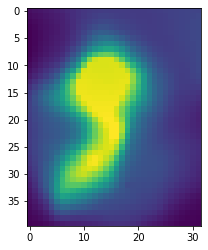

In [19]:
plt.imshow(A2)


## Dual Band Calculation : Threshold from TEI

In [20]:
BT1 = A1+273.15 # Conversion to Kelvin
BT2 = A2+273.15 # Conversion to Kelvin
N = A3 # Create TEI files into array
Tc= (BT2-BT2)+273.15+10 #Cold temperature Assumption, in this case 20 degrees C and convert to Array and Kelvin
Thstart= Tc # Th start same with Tc

In [21]:
for i in range(0, iiter):
    for j in range(0, jiter):
        if N[i,j] >= 1.2 :
            Tc[i,j] = (BT2[i,j] - BT2[i,j]) + 273.15 + 151
        elif N[i,j] > 0.9 and N[i,j] < 1.2:
            Tc[i,j] = (BT2[i,j]-BT2[i,j])+273.15+140
        elif N[i,j] > 0.6 and N[i,j] < 0.9:
            Tc[i,j] = (BT2[i,j]-BT2[i,j])+273.15+114
        elif N[i,j] > 0.3 and N[i,j] < 0.6:
            Tc[i,j] = (BT2[i,j]-BT2[i,j])+273.15+75
        else:
            Tc[i,j] = (BT2[i,j]-BT2[i,j])+273.15+34
        Thstart[i,j] = Tc[i,j]


307.15


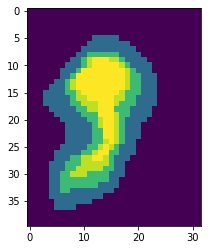

In [115]:
plt.imshow(Tc)
print(np.min(Tc))

## Dual Band Calculation : Planck Inversion

In [25]:
maxBT1 = np.max(BT1)
maxBT2 = np.max(BT2)
print(maxBT1)
print(maxBT2)

764.7025817871094
442.4570373535156


In [26]:
Th = np.full((iiter, jiter), 293.15)
# Thstart2 = np.full((30, 35), 293.15)
p1 = np.zeros((iiter, jiter))
p2 = np.zeros((iiter, jiter))
for i in range(0, iiter):
    for j in range(0, jiter):
        if maxBT1 < maxBT2:
            Th[i,j] = maxBT2 + 1
        else:
            Th[i,j] = maxBT1 + 1
print(Th)



[[765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]
 [765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]
 [765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]
 ...
 [765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]
 [765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]
 [765.70258179 765.70258179 765.70258179 ... 765.70258179 765.70258179
  765.70258179]]


41.27876887818971


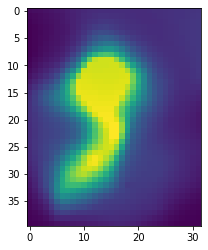

In [27]:
M1 = np.zeros((iiter, jiter))
M2 = np.zeros((iiter, jiter))
Mh1 = np.zeros((iiter, jiter))
Mh2 = np.zeros((iiter, jiter))
Mc1 = np.zeros((iiter, jiter))
Mc2 = np.zeros((iiter, jiter))
# TT1 = np.zeros((30, 35))
# TT2 = np.zeros((30, 35))
# Thstart2 = np.full((30, 35), 293.15)
p1 = np.zeros((iiter, jiter))
p2 = np.zeros((iiter, jiter))
for i in range(0, iiter):
    for j in range(0, jiter):
        M1[i,j] = radiance(BT1[i,j],cw1)
        M2[i,j] = radiance(BT2[i,j],cw2)
        Mh1[i,j] = radiance(Th[i,j],cw1)
        Mh2[i,j] = radiance(Th[i,j],cw2)
        Mc1[i,j] = radiance(Tc[i,j],cw1)
        Mc2[i,j] = radiance(Tc[i,j],cw2)
# for i in range(0,30):
#     for j in range(0,35):
#         TT1[i,j] = temperature(M1[i,j],cw1)
#         TT2[i,j] = temperature(M2[i,j],cw2)    
plt.imshow(M2)
print(np.max(M2))

pixel position (x, y):  0 0
ratio :  12.182536485856861
p1 & p2 :  0.06512365851812273 0.005345656759881416
pixel position (x, y):  0 1
ratio :  8.917033734542622
p1 & p2 :  0.06028869260247158 0.006761070373539855
pixel position (x, y):  0 2
ratio :  7.188942319637623
p1 & p2 :  0.05787924561507784 0.008051148978754832
pixel position (x, y):  0 3
ratio :  5.862523593926437
p1 & p2 :  0.055046583916471305 0.009389571408036541
pixel position (x, y):  0 4
ratio :  4.853974033835613
p1 & p2 :  0.052262613376281124 0.010766974238422773
pixel position (x, y):  0 5
ratio :  4.2295281046994795
p1 & p2 :  0.05211612368119792 0.012321971243858403
pixel position (x, y):  0 6
ratio :  3.7243863218722373
p1 & p2 :  0.052718523499608184 0.014154955727875928
pixel position (x, y):  0 7
ratio :  3.2713046642222183
p1 & p2 :  0.052637115258937085 0.016090557334699374
pixel position (x, y):  0 8
ratio :  2.767138743414033
p1 & p2 :  0.05026015476959884 0.01816322180780462
pixel position (x, y):  0 9
ra

pixel position (x, y):  6 22
ratio :  1.4274596867029565
p1 & p2 :  0.04119151540253711 0.0288565174808392
pixel position (x, y):  6 23
ratio :  1.7374287714751284
p1 & p2 :  0.046727212583818394 0.02689446229450063
pixel position (x, y):  6 24
ratio :  1.9179602977507046
p1 & p2 :  0.049950802187141534 0.026043710209080726
pixel position (x, y):  6 25
ratio :  1.8510001108483158
p1 & p2 :  0.04778548751028138 0.025816037087313424
pixel position (x, y):  6 26
ratio :  1.746492795319384
p1 & p2 :  0.04586431860662837 0.026260811799249984
pixel position (x, y):  6 27
ratio :  1.6382737446806
p1 & p2 :  0.04446410803400475 0.02714082928959686
pixel position (x, y):  6 28
ratio :  1.6492277347245994
p1 & p2 :  0.046401601042909905 0.02813535090753152
pixel position (x, y):  6 29
ratio :  1.7475561472425938
p1 & p2 :  0.05107415804919512 0.029226046974103352
pixel position (x, y):  6 30
ratio :  1.688732313773703
p1 & p2 :  0.0510416081082693 0.03022480691105499
pixel position (x, y):  6 31

ratio :  7.4809879063868205
p1 & p2 :  0.07721792833508323 0.010321889207862396
pixel position (x, y):  13 6
ratio :  0.9996683972444462
p1 & p2 :  0.02828053706029721 0.0282899180750853
pixel position (x, y):  13 7
ratio :  0.9994057542171217
p1 & p2 :  0.005690135379209464 0.005693518728703734
pixel position (x, y):  13 8
ratio :  0.999997673856149
p1 & p2 :  0.00013307368313693698 0.0001330739926861868
pixel position (x, y):  13 9
ratio :  0.9998680252139586
p1 & p2 :  0.01612048702569209 0.01612261480433132
pixel position (x, y):  13 10
ratio :  0.9998519937211381
p1 & p2 :  0.012947461829867984 0.012949378419181382
pixel position (x, y):  13 11
ratio :  0.999809087039287
p1 & p2 :  0.010509677617523612 0.01051168443432105
pixel position (x, y):  13 12
ratio :  0.9997618706269108
p1 & p2 :  0.009217682055494305 0.00921987757916219
pixel position (x, y):  13 13
ratio :  0.9998849514496438
p1 & p2 :  0.009077197428792125 0.009078241867358748
pixel position (x, y):  13 14
ratio :  0.9

ratio :  1.3051677312969472
p1 & p2 :  0.044040770498946405 0.03374337982994954
pixel position (x, y):  19 25
ratio :  1.520658461404575
p1 & p2 :  0.042803425018679 0.028147954392824727
pixel position (x, y):  19 26
ratio :  1.8246110728653566
p1 & p2 :  0.04324303068443937 0.023699862029517783
pixel position (x, y):  19 27
ratio :  1.9138560786920558
p1 & p2 :  0.04075192042603629 0.02129309558840311
pixel position (x, y):  19 28
ratio :  2.2979744438656335
p1 & p2 :  0.04485488626767906 0.019519314667496714
pixel position (x, y):  19 29
ratio :  3.374562126914909
p1 & p2 :  0.05984911167339367 0.01773537111557312
pixel position (x, y):  19 30
ratio :  4.762959738912377
p1 & p2 :  0.07503731410501839 0.015754345662840556
pixel position (x, y):  19 31
ratio :  6.037860138483191
p1 & p2 :  0.08026257525031164 0.013293215379194739
pixel position (x, y):  20 0
ratio :  1.508319542423581
p1 & p2 :  0.03889576727939504 0.02578748480371539
pixel position (x, y):  20 1
ratio :  1.23004613778

ratio :  0.9988317001370727
p1 & p2 :  0.08681532518417666 0.08691687015166091
pixel position (x, y):  26 16
ratio :  0.9992687539990551
p1 & p2 :  0.045021816535801853 0.04505476265081378
pixel position (x, y):  26 17
ratio :  0.9997888836878611
p1 & p2 :  0.05298632069355937 0.05299750933228215
pixel position (x, y):  26 18
ratio :  3.1843399278407327
p1 & p2 :  0.04319341563145289 0.013564323096856649
pixel position (x, y):  26 19
ratio :  11.828922851282751
p1 & p2 :  0.04586355576595968 0.003877238556931339
pixel position (x, y):  26 20
ratio :  1.0511048759939905
p1 & p2 :  0.04539214402181627 0.04318517120272192
pixel position (x, y):  26 21
ratio :  1.079629003659258
p1 & p2 :  0.04167995512667157 0.038605812724003284
pixel position (x, y):  26 22
ratio :  1.221981200704459
p1 & p2 :  0.04446410803400475 0.0363869002308478
pixel position (x, y):  26 23
ratio :  1.2948753415241765
p1 & p2 :  0.045440971275169904 0.03509293120191947
pixel position (x, y):  26 24
ratio :  1.361856

p1 & p2 :  0.041338041843205976 0.025949248311315155
pixel position (x, y):  33 3
ratio :  1.2805485513494674
p1 & p2 :  0.04895771021067084 0.0382318266332645
pixel position (x, y):  33 4
ratio :  3.5832489836868286
p1 & p2 :  0.052001378885407464 0.014512354324845968
pixel position (x, y):  33 5
ratio :  0.9999934948869471
p1 & p2 :  0.04342233593643009 0.043422618405471874
pixel position (x, y):  33 6
ratio :  0.9995821621952345
p1 & p2 :  0.009048807376084612 0.009052589890371847
pixel position (x, y):  33 7
ratio :  0.999689596875104
p1 & p2 :  0.011231206068310143 0.011234693352233925
pixel position (x, y):  33 8
ratio :  0.9994341423059058
p1 & p2 :  0.07265855547164021 0.07269969315236877
pixel position (x, y):  33 9
ratio :  0.9994042095593987
p1 & p2 :  0.06640447464715507 0.06644406138376224
pixel position (x, y):  33 10
ratio :  0.9997060450768783
p1 & p2 :  0.05697660638576215 0.05699335986447956
pixel position (x, y):  33 11
ratio :  0.9993449099603964
p1 & p2 :  0.046021

p1 & p2 :  0.03940050057274974 0.01938822220211257
pixel position (x, y):  39 19
ratio :  2.130217399421749
p1 & p2 :  0.039416770126583754 0.018503637298842596
pixel position (x, y):  39 20
ratio :  2.348885840036931
p1 & p2 :  0.03817933186426323 0.016254230500901204
pixel position (x, y):  39 21
ratio :  2.4660202635857678
p1 & p2 :  0.03252926201743936 0.013190995426022784
pixel position (x, y):  39 22
ratio :  2.7291129555894207
p1 & p2 :  0.029419125306543892 0.01077973897939673
pixel position (x, y):  39 23
ratio :  3.3883314128585176
p1 & p2 :  0.030444992022905033 0.008985246221006625
pixel position (x, y):  39 24
ratio :  4.010901376673578
p1 & p2 :  0.028881757740579765 0.007200814736694601
pixel position (x, y):  39 25
ratio :  4.993600638292044
p1 & p2 :  0.027123041747193453 0.005431560052922117
pixel position (x, y):  39 26
ratio :  8.040250877856277
p1 & p2 :  0.027969845578073162 0.0034787279654550523
pixel position (x, y):  39 27
ratio :  13.839900290478797
p1 & p2 : 

p1 & p2 :  0.07801620963576122 0.004591328543735295
pixel position (x, y):  6 3
ratio :  9.562211451828537
p1 & p2 :  0.06546546948222459 0.006846268754044958
pixel position (x, y):  6 4
ratio :  8.651817182148166
p1 & p2 :  0.07803249124513242 0.009019202509981571
pixel position (x, y):  6 5
ratio :  7.5766492095769244
p1 & p2 :  0.0839576243778668 0.011081102220193054
pixel position (x, y):  6 6
ratio :  6.2284852198971565
p1 & p2 :  0.08205311063528632 0.013173846888672743
pixel position (x, y):  6 7
ratio :  5.012275161213459
p1 & p2 :  0.08449478778604431 0.016857571675212728
pixel position (x, y):  6 8
ratio :  4.185270891963483
p1 & p2 :  0.09330083121635163 0.022292662440442503
pixel position (x, y):  6 9
ratio :  3.0421616188112885
p1 & p2 :  0.08892227548510831 0.029229964290935436
pixel position (x, y):  6 10
ratio :  2.283248831915944
p1 & p2 :  0.08918269697303942 0.03905956097575378
pixel position (x, y):  6 11
ratio :  11.568328101799565
p1 & p2 :  0.07773880883297955 0.

pixel position (x, y):  12 25
ratio :  1.4984587882607747
p1 & p2 :  0.05299522864760157 0.035366490598725014
pixel position (x, y):  12 26
ratio :  1.5697451274696537
p1 & p2 :  0.04851808535793393 0.030908256702884322
pixel position (x, y):  12 27
ratio :  1.6315510450239914
p1 & p2 :  0.04506653274044639 0.027621895666637697
pixel position (x, y):  12 28
ratio :  1.8909230509420218
p1 & p2 :  0.048794859711227066 0.02580478337651995
pixel position (x, y):  12 29
ratio :  2.0104504056064205
p1 & p2 :  0.052181279580515265 0.025955019549350984
pixel position (x, y):  12 30
ratio :  1.92907256549601
p1 & p2 :  0.05384180891662121 0.027910722426751848
pixel position (x, y):  12 31
ratio :  1.6240689060788633
p1 & p2 :  0.04825763294505731 0.029714030460425526
pixel position (x, y):  13 0
ratio :  3.5449402369057457
p1 & p2 :  0.049771704862741496 0.01404020985870991
pixel position (x, y):  13 1
ratio :  1.6037484631959569
p1 & p2 :  0.032398959938210445 0.020202020879038385
pixel positi

p1 & p2 :  0.04174434355518105 0.007738352699096515
pixel position (x, y):  19 6
ratio :  2.9396495777665548
p1 & p2 :  0.04597751023500909 0.015640473130794464
pixel position (x, y):  19 7
ratio :  1.0003474550668827
p1 & p2 :  0.02136507683164191 0.02135765600584594
pixel position (x, y):  19 8
ratio :  1.0006049936306387
p1 & p2 :  0.03876219066072152 0.03873875396131605
pixel position (x, y):  19 9
ratio :  1.0011112164904354
p1 & p2 :  0.061325398069042525 0.061257327916102146
pixel position (x, y):  19 10
ratio :  1.0008477104816678
p1 & p2 :  0.022462340022006057 0.02244331458898561
pixel position (x, y):  19 11
ratio :  1.000785249070945
p1 & p2 :  0.06160114111572838 0.06155280683135001
pixel position (x, y):  19 12
ratio :  1.00051940960174
p1 & p2 :  0.10687520215457558 0.10681971896688901
pixel position (x, y):  19 13
ratio :  1.000330033341866
p1 & p2 :  0.027014811074858924 0.027005898228016637
pixel position (x, y):  19 14
ratio :  1.0002866729086508
p1 & p2 :  0.0139169

p1 & p2 :  0.03943304549719178 0.024299962891193023
pixel position (x, y):  25 28
ratio :  1.7366117338436253
p1 & p2 :  0.03861896236761671 0.022238109771458094
pixel position (x, y):  25 29
ratio :  1.7066574606971552
p1 & p2 :  0.03516709710645308 0.02060583211120034
pixel position (x, y):  25 30
ratio :  1.780648031855451
p1 & p2 :  0.034190119041342636 0.019200941696330763
pixel position (x, y):  25 31
ratio :  1.899733124314337
p1 & p2 :  0.03391333180740337 0.017851629459608213
pixel position (x, y):  26 0
ratio :  1.6845161571348548
p1 & p2 :  0.04026346927282353 0.02390209740778415
pixel position (x, y):  26 1
ratio :  1.408638258601513
p1 & p2 :  0.0408821479121173 0.02902246028210595
pixel position (x, y):  26 2
ratio :  1.2361882510051634
p1 & p2 :  0.04203816365105928 0.0340062798824349
pixel position (x, y):  26 3
ratio :  1.0741345769015618
p1 & p2 :  0.04267317105483783 0.03972795585626938
pixel position (x, y):  26 4
ratio :  0.944339243040932
p1 & p2 :  0.043650059715

ratio :  2.21193977342696
p1 & p2 :  0.05130137575394492 0.023192935164985825
pixel position (x, y):  32 16
ratio :  4.865084265027874
p1 & p2 :  0.045326258297405365 0.009316644034971443
pixel position (x, y):  32 17
ratio :  0.8825657239312333
p1 & p2 :  0.03723497234456705 0.04218946117543567
pixel position (x, y):  32 18
ratio :  1.096697064014058
p1 & p2 :  0.03703957993375244 0.03377375680954467
pixel position (x, y):  32 19
ratio :  1.0801834863367241
p1 & p2 :  0.036258017480588496 0.03356653562956417
pixel position (x, y):  32 20
ratio :  1.1164302427419721
p1 & p2 :  0.03759316722199758 0.033672652157530326
pixel position (x, y):  32 21
ratio :  1.2989447039320055
p1 & p2 :  0.04241267170179426 0.03265163757426151
pixel position (x, y):  32 22
ratio :  1.4123402260979052
p1 & p2 :  0.04540843726937147 0.03215120296816052
pixel position (x, y):  32 23
ratio :  1.569268699141051
p1 & p2 :  0.04915302630703354 0.031322249869597064
pixel position (x, y):  32 24
ratio :  1.4326298

pixel position (x, y):  39 3
ratio :  8.336791646221378
p1 & p2 :  0.029647069749117353 0.0035561725670036127
pixel position (x, y):  39 4
ratio :  4.931891320544493
p1 & p2 :  0.02925625779706657 0.005932056465882667
pixel position (x, y):  39 5
ratio :  3.2350385629736422
p1 & p2 :  0.02743246157107241 0.00847979430138741
pixel position (x, y):  39 6
ratio :  2.575314339056139
p1 & p2 :  0.027644164815884296 0.010734287615552195
pixel position (x, y):  39 7
ratio :  2.3636159545511792
p1 & p2 :  0.02790469232305447 0.011805933307110892
pixel position (x, y):  39 8
ratio :  2.353456809519619
p1 & p2 :  0.028784048572094465 0.012230540393035632
pixel position (x, y):  39 9
ratio :  2.244744762511908
p1 & p2 :  0.02907712167205722 0.012953419986831563
pixel position (x, y):  39 10
ratio :  2.396823256697224
p1 & p2 :  0.03303402685952697 0.01378242086362564
pixel position (x, y):  39 11
ratio :  2.5540729456317766
p1 & p2 :  0.03720241144948308 0.014565915790741315
pixel position (x, y)

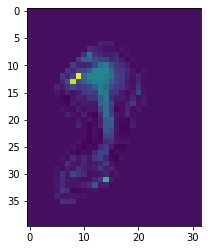

In [81]:
p1 = (M1 - Mc1) / (Mh1 - Mc1)
p2 = (M2 - Mc2) / (Mh2 - Mc2)
ratio = p1/p2


for i in range(0, iiter):
    for j in range(0, jiter):
        while(ratio[i,j]>1.0 and N[i,j]>0.4):
            Th[i,j] = Th[i,j] + 0.1
            Mh1[i,j] = radiance(Th[i,j],cw1)
            Mh2[i,j] = radiance(Th[i,j],cw2)
            p1[i,j] = (M1[i,j] - Mc1[i,j]) / (Mh1[i,j] - Mc1[i,j])
            p2[i,j] = (M2[i,j] - Mc2[i,j]) / (Mh2[i,j] - Mc2[i,j])
            ratio[i,j] = p1[i,j]/p2[i,j]
        print('pixel position (x, y): ', i, j)
        print("ratio : ", ratio[i,j])
        print('p1 & p2 : ', p1[i,j], p2[i,j])
for i in range(0, iiter):
    for j in range(0, jiter):
        while(ratio[i,j]<1.0 and N[i,j]>0.4):
            Th[i,j] = Th[i,j] - 0.1
            Mh1[i,j] = radiance(Th[i,j],cw1)
            Mh2[i,j] = radiance(Th[i,j],cw2)
            p1[i,j] = (M1[i,j] - Mc1[i,j]) / (Mh1[i,j] - Mc1[i,j])
            p2[i,j] = (M2[i,j] - Mc2[i,j]) / (Mh2[i,j] - Mc2[i,j])
            ratio[i,j] = p1[i,j]/p2[i,j]
        print('pixel position (x, y): ', i, j)
        print("ratio : ", ratio[i,j])
        print('p1 & p2 : ', p1[i,j], p2[i,j])
plt.imshow(Th)

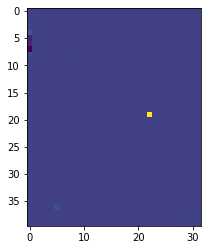

In [82]:
Thcel = Th - 273.15
Tccel = Tc - 273.15
plt.imshow(ratio)

# Data Cleaning

4114.557960608219


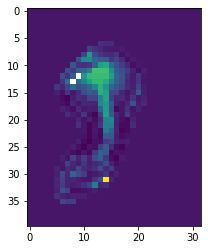

In [83]:

Thcelclean = np.zeros((iiter, jiter))
for i in range(0, iiter):
    for j in range(0, jiter):
        if Thcel[i,j] > 1300:
            Thcelclean[i,j] = None
        else:
            Thcelclean[i,j] = Thcel[i,j]

print(np.max(ratio))
plt.imshow(Thcelclean)

1.096697064014058


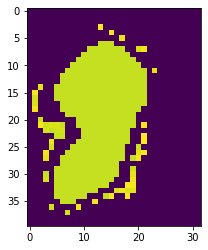

In [84]:
fh = ratio
for i in range(0, iiter):
    for j in range(0, jiter):
        if fh[i,j] > 1.1 or fh[i,j] < 0.99:
            fh[i,j] = 0.0
        else:
            fh[i,j] = fh[i,j]
plt.imshow(ratio)
print(np.max(fh))

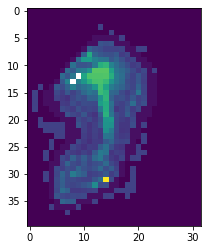

In [106]:

Te = (fh*(Thcelclean**4) + (1-fh)*(Tc**4))**(1/4)
plt.imshow(Te)

nan


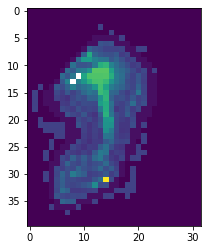

In [121]:
sb = 5.6e-8 # stefan-boltzman constant (Wm^-2 K^-4)
em = 0.97
hc = 5 #heat transfer coefficient (m^-2 k^-1) 
Ta = np.min(Tc-273.15)
area = 900
radflux = em*sb*area*(Te**4)
radfluxmega = radflux/1000000
conflux = area*hc*(Te-Ta)
confluxmega = conflux / 1000000
print(np.max(conflux))
plt.imshow((conflux))

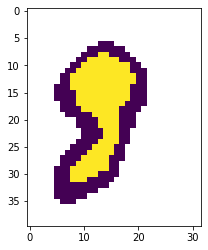

In [123]:
#Crust Thickness
Ti = np.zeros((iiter, jiter))
for i in range(0, iiter):
    for j in range(0, jiter):
        if N[i,j] > 0.4 and N[i,j] < 0.8:
            Ti[i,j] = 1100
        elif N[i,j] > 0.8:
            Ti[i,j] = 1300
        else:
            Ti[i,j] = None
plt.imshow(Ti)


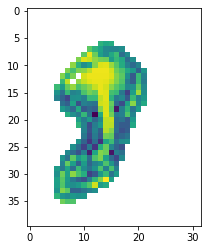

In [124]:
k = 2.6 #Thermal Conductivity (Wm^-1K^-1)
dh = -k * (Ti - Te)/(radflux + conflux)
plt.imshow(dh)

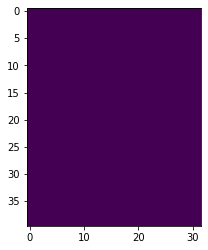

In [58]:
print(ratio)

# Export Raster

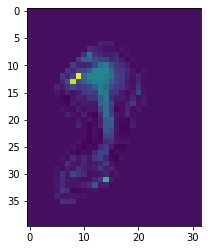

In [125]:
def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

arr_shape, array_ds = read_geotiff("D:/Study/Bachelor Thesis (Skripsi)/Krakatau/BTSWIR_test_celcius")
# nlcd16_arr, nlcd16_ds = read_geotiff("nlcd2016_clipped.tif")
plt.imshow(Th)
# nlcd_changed = np.where(nlcd01_arr != nlcd16_arr, 1, 0)

write_geotiff("D:/Study/Bachelor Thesis (Skripsi)/Krakatau/dh.tif", dh, array_ds)

# plt.subplot(311)
# plt.imshow(nlcd01_arr)

# plt.subplot(312)
# plt.imshow(nlcd16_arr)

# plt.subplot(313)
# plt.imshow(nlcd_changed)

# plt.show()